### Import dataframe

In [20]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
import numpy as np
import psycopg2
import pandas as pd
import pickle

### Create dataframes for plotting

In [21]:
# Load data
df = pd.read_pickle('/Users/mai/Desktop/yelp_dataset/to_submit/restaurants_clean.pickle')

In [23]:
df.head()

,business_id,review_id,minyear,maxyear,estimated_opearating_years,total_checkins,total_checkinyear_count,city,business_status,latitude,...,food_type_Seafood,food_type_Soup,food_type_Steakhouses,food_type_Sushi Bars,food_type_Tacos,food_type_Tapas Bars,food_type_Uzbek,food_type_Waffles,food_type_Wraps,prediction_col
1,--6MefnULPED_I942VcFNA,46,2011,2018,7,167,8,Richmond Hill,1,43.841694,...,0,0,0,0,0,0,0,0,0,successful
2,--7zmmkVg-IMGaXbuVd0SQ,59,2014,2018,4,180,5,Huntersville,1,35.437106,...,0,0,0,0,0,0,0,0,0,successful
3,--9e1ONYQuAa-CB_Rrw7Tw,1661,2010,2018,8,2770,9,Las Vegas,1,36.123183,...,0,0,1,0,0,0,0,0,0,successful
4,--DaPTJW3-tB1vP-PfdTEg,49,2012,2018,6,95,7,Toronto,1,43.677807,...,0,0,0,0,0,0,0,0,0,successful
5,--FBCX-N37CMYDfs790Bnw,142,2010,2018,8,528,9,Henderson,1,35.978679,...,0,0,0,0,0,0,0,0,0,successful


In [24]:
# Create a DataFrame to show the number of businesses per state
total_businesses = pd.DataFrame(df.groupby('US_state').count()['business_id'])
total_businesses = total_businesses.reset_index()
total_businesses.rename(columns={'business_id': 'total_businesses'}, inplace=True)
total_businesses = total_businesses.sort_values(by='US_state')

In [25]:
# Create a DataFrame to show the average star rating per state
avg_rating_state = pd.DataFrame(df.groupby('US_state').mean()['average_stars_per_business']).round(2)
avg_rating_state = avg_rating_state.reset_index()
avg_rating_state.rename(columns={'average_stars_per_business': 'average_stars_per_state'}, inplace=True)
avg_rating_state = avg_rating_state.sort_values(by='US_state')

In [26]:
# Create a DataFrame to show the number of businesses per state
sum_checkins_state = pd.DataFrame(df.groupby('US_state').sum()['total_checkins'])
sum_checkins_state = sum_checkins_state.reset_index()
sum_checkins_state = avg_rating_state.sort_values(by='US_state')

In [27]:
# Create a DataFrame to show the total review count per state
sum_review_state = pd.DataFrame(df.groupby('US_state').sum()['review_count_per_business'])
sum_review_state = sum_review_state.reset_index()
sum_review_state.rename(columns={'review_count_per_business': 'total_reviews_per_state'}, inplace=True)
sum_review_state = sum_review_state.sort_values(by='US_state')

In [28]:
# Merge all the DataFrames created above
state_df = pd.concat([total_businesses, avg_rating_state.iloc[:, 1:], sum_checkins_state.iloc[:, 1:], sum_review_state.iloc[:, 1:]], axis=1)
state_df.sort_values(by='total_businesses', ascending=False).head()

,US_state,total_businesses,average_stars_per_state,average_stars_per_state,total_reviews_per_state
13,ON,13568,3.37,3.37,527409
2,AZ,11892,3.39,3.39,1095876
10,NV,8147,3.39,3.39,1282275
12,OH,5392,3.44,3.44,213203
15,QC,4611,3.66,3.66,129800


In [29]:
# Save the data to visualise them on Tableau
state_df.to_csv('states.csv')

In [31]:
# Create a DataFrame to show the distribution of business status
business_status = pd.DataFrame(df.groupby(['prediction_col']).count()['business_id'])
business_status = business_status.reset_index()
business_status.rename(columns={'business_id': 'total_businesses'}, inplace=True)
business_status.sort_values(by='prediction_col', ascending=False)

,prediction_col,total_businesses
1,successful,38588
0,failed,18896


In [32]:
# Create a DataFrame to show the distribution of price range
# List up columns that contains price range information
price_columns = []
for i in df.columns:
    if 'price' in i:
        price_columns.append(i)
price_columns

['pricerange_1',
 'pricerange_2',
 'pricerange_3',
 'pricerange_4',
 'pricerange_unknown']

In [33]:
# Create a DataFrame that contains information required for next steps
price = df[['business_id', 'US_state', 'pricerange_1', 'pricerange_2', 'pricerange_3', 'pricerange_4', 'pricerange_unknown']]

In [34]:
# Currently I have one column per price range 
# I want to create one column that contains all price range information
ratings = []

for i in range(len(price)):
    price_range_list = list(price.iloc[i,1:])
    # Find where it is 1.0 
    try:
        rating = price_range_list.index(1.0)
    except: 
        rating = np.NaN
    ratings.append(rating)

In [35]:
# Create a column in the Price DataFrame
price['pricerange'] = ratings

# Check the number of businesses per price range
pricerange = pd.DataFrame(price.groupby('pricerange').count()['business_id'])
pricerange = pricerange.reset_index()
pricerange.rename(columns={'business_id': 'total_businesses'}, inplace=True)

# Show the DataFrame on Jupyter Notebook
pricerange

,pricerange,total_businesses
0,1.0,22326
1,2.0,28227
2,3.0,3026
3,4.0,513
4,5.0,38


In [39]:
# Load data
cuisine_foodtype = pd.read_pickle('/Users/mai/Desktop/yelp_dataset/to_submit/cuisine_foodtype.pickle')

In [40]:
# Create a DataFrame to show the distribution of cuisines
cuisine = pd.DataFrame(cuisine_foodtype.groupby(['cuisine']).count()['business_id'])
cuisine = cuisine.reset_index()
cuisine.rename(columns={'business_id': 'total_businesses'}, inplace=True)
cuisine = cuisine.sort_values(by='total_businesses', ascending=False)
cuisine.head()

,cuisine,total_businesses
1,American,8880
26,Mexican,4546
21,Italian,4459
11,Chinese,3605
22,Japanese,2362


In [41]:
# Create a DataFrame to show the distribution of food type
food = pd.DataFrame(cuisine_foodtype.groupby(['food_type']).count()['business_id'])
food = food.reset_index()
food.rename(columns={'business_id': 'total_businesses'}, inplace=True)
food = food.sort_values(by='total_businesses', ascending=False)
food.head()

,food_type,total_businesses
38,Sandwiches,6624
13,Coffee & Tea,5599
33,Pizza,5226
20,Fast Food,4661
42,Sushi Bars,2233


### EDA

#### Check the distribution of businesses per state

In [42]:
# Check the number of states in the DataFrame
len(state_df['US_state'])

20

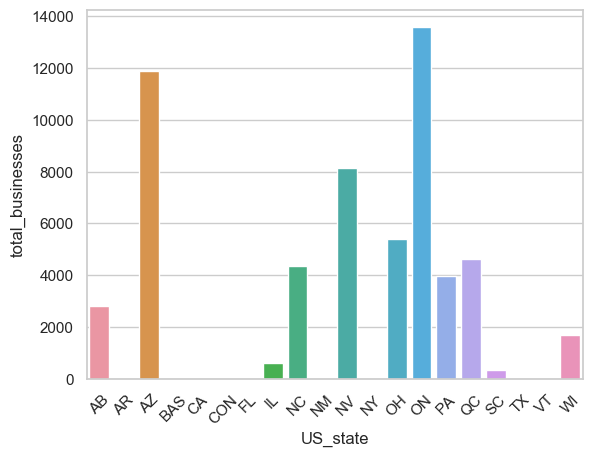

In [43]:
# Plot the distribution of business per state
# Some states have many information but others do not 
# It seems the dataset was edited by the Yelp team before publishing them on their Data Set Challenge page
sns.set(style="whitegrid")
plt.xticks(rotation=45)
sns.barplot(x='US_state', y='total_businesses', data=state_df);

#### Check the distribution of businesses per price range

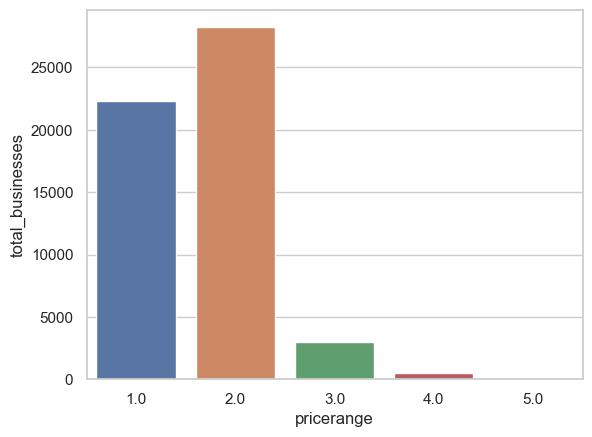

In [44]:
# Most of the restaurants included in the dataset are $-$$ price range, considered as cheap options. 
# I was expecting to find evenly distributed results across the price range. 
# Thus, it was necessary to focus on analyzing more inexpensive restaurants. 
sns.set(style="whitegrid")
sns.barplot(x='pricerange', y='total_businesses', data=pricerange);

#### Check the distribution of busiensses  per business status

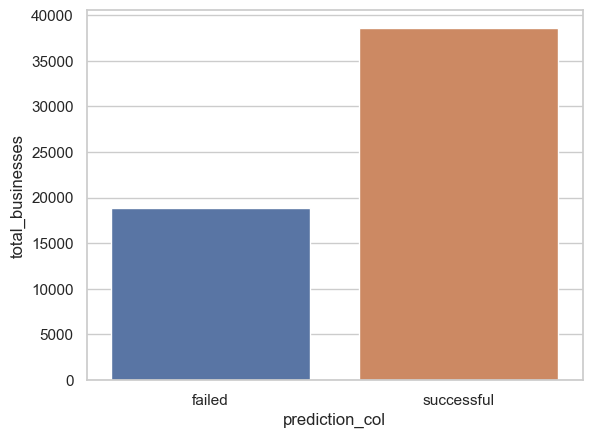

In [45]:
# There are twice more successful business data than those failed
sns.set(style="whitegrid")
sns.barplot(x='prediction_col', y='total_businesses', data=business_status);

#### Check the distribution of businesses per cuisine

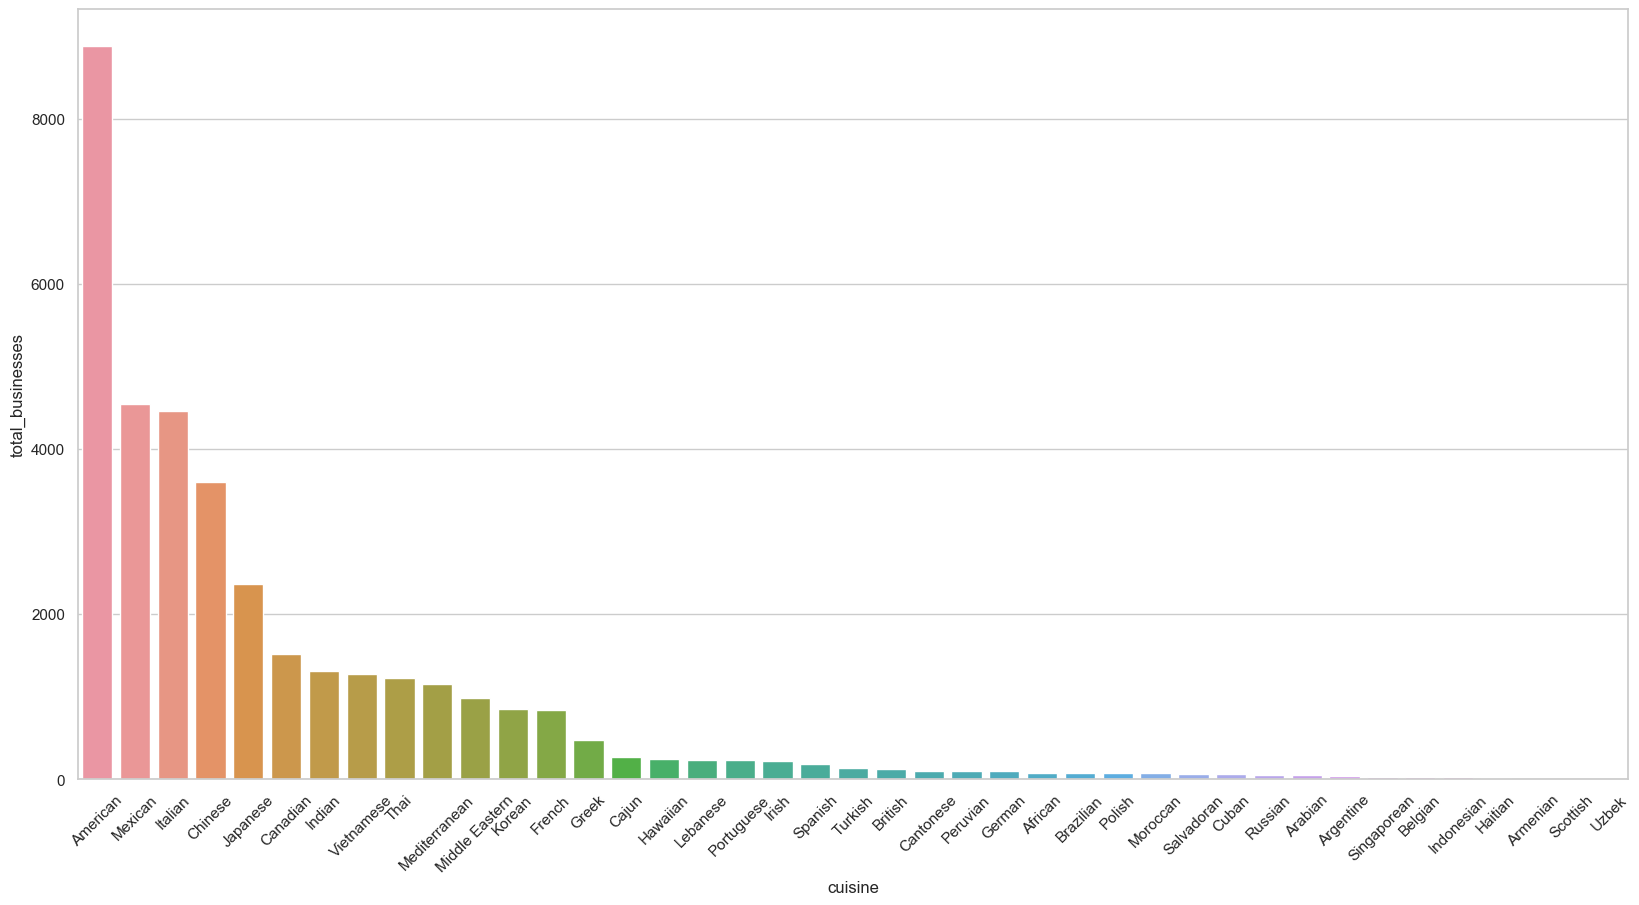

In [46]:
# Business attribute column included 20+ different cuisine types. 
# American, Mexican and Italian are most common.
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.barplot(x='cuisine', y='total_businesses', data=cuisine);
plt.savefig('Q1_model_performance.jpg', bbox_inches="tight")

#### Check the distribution of food type

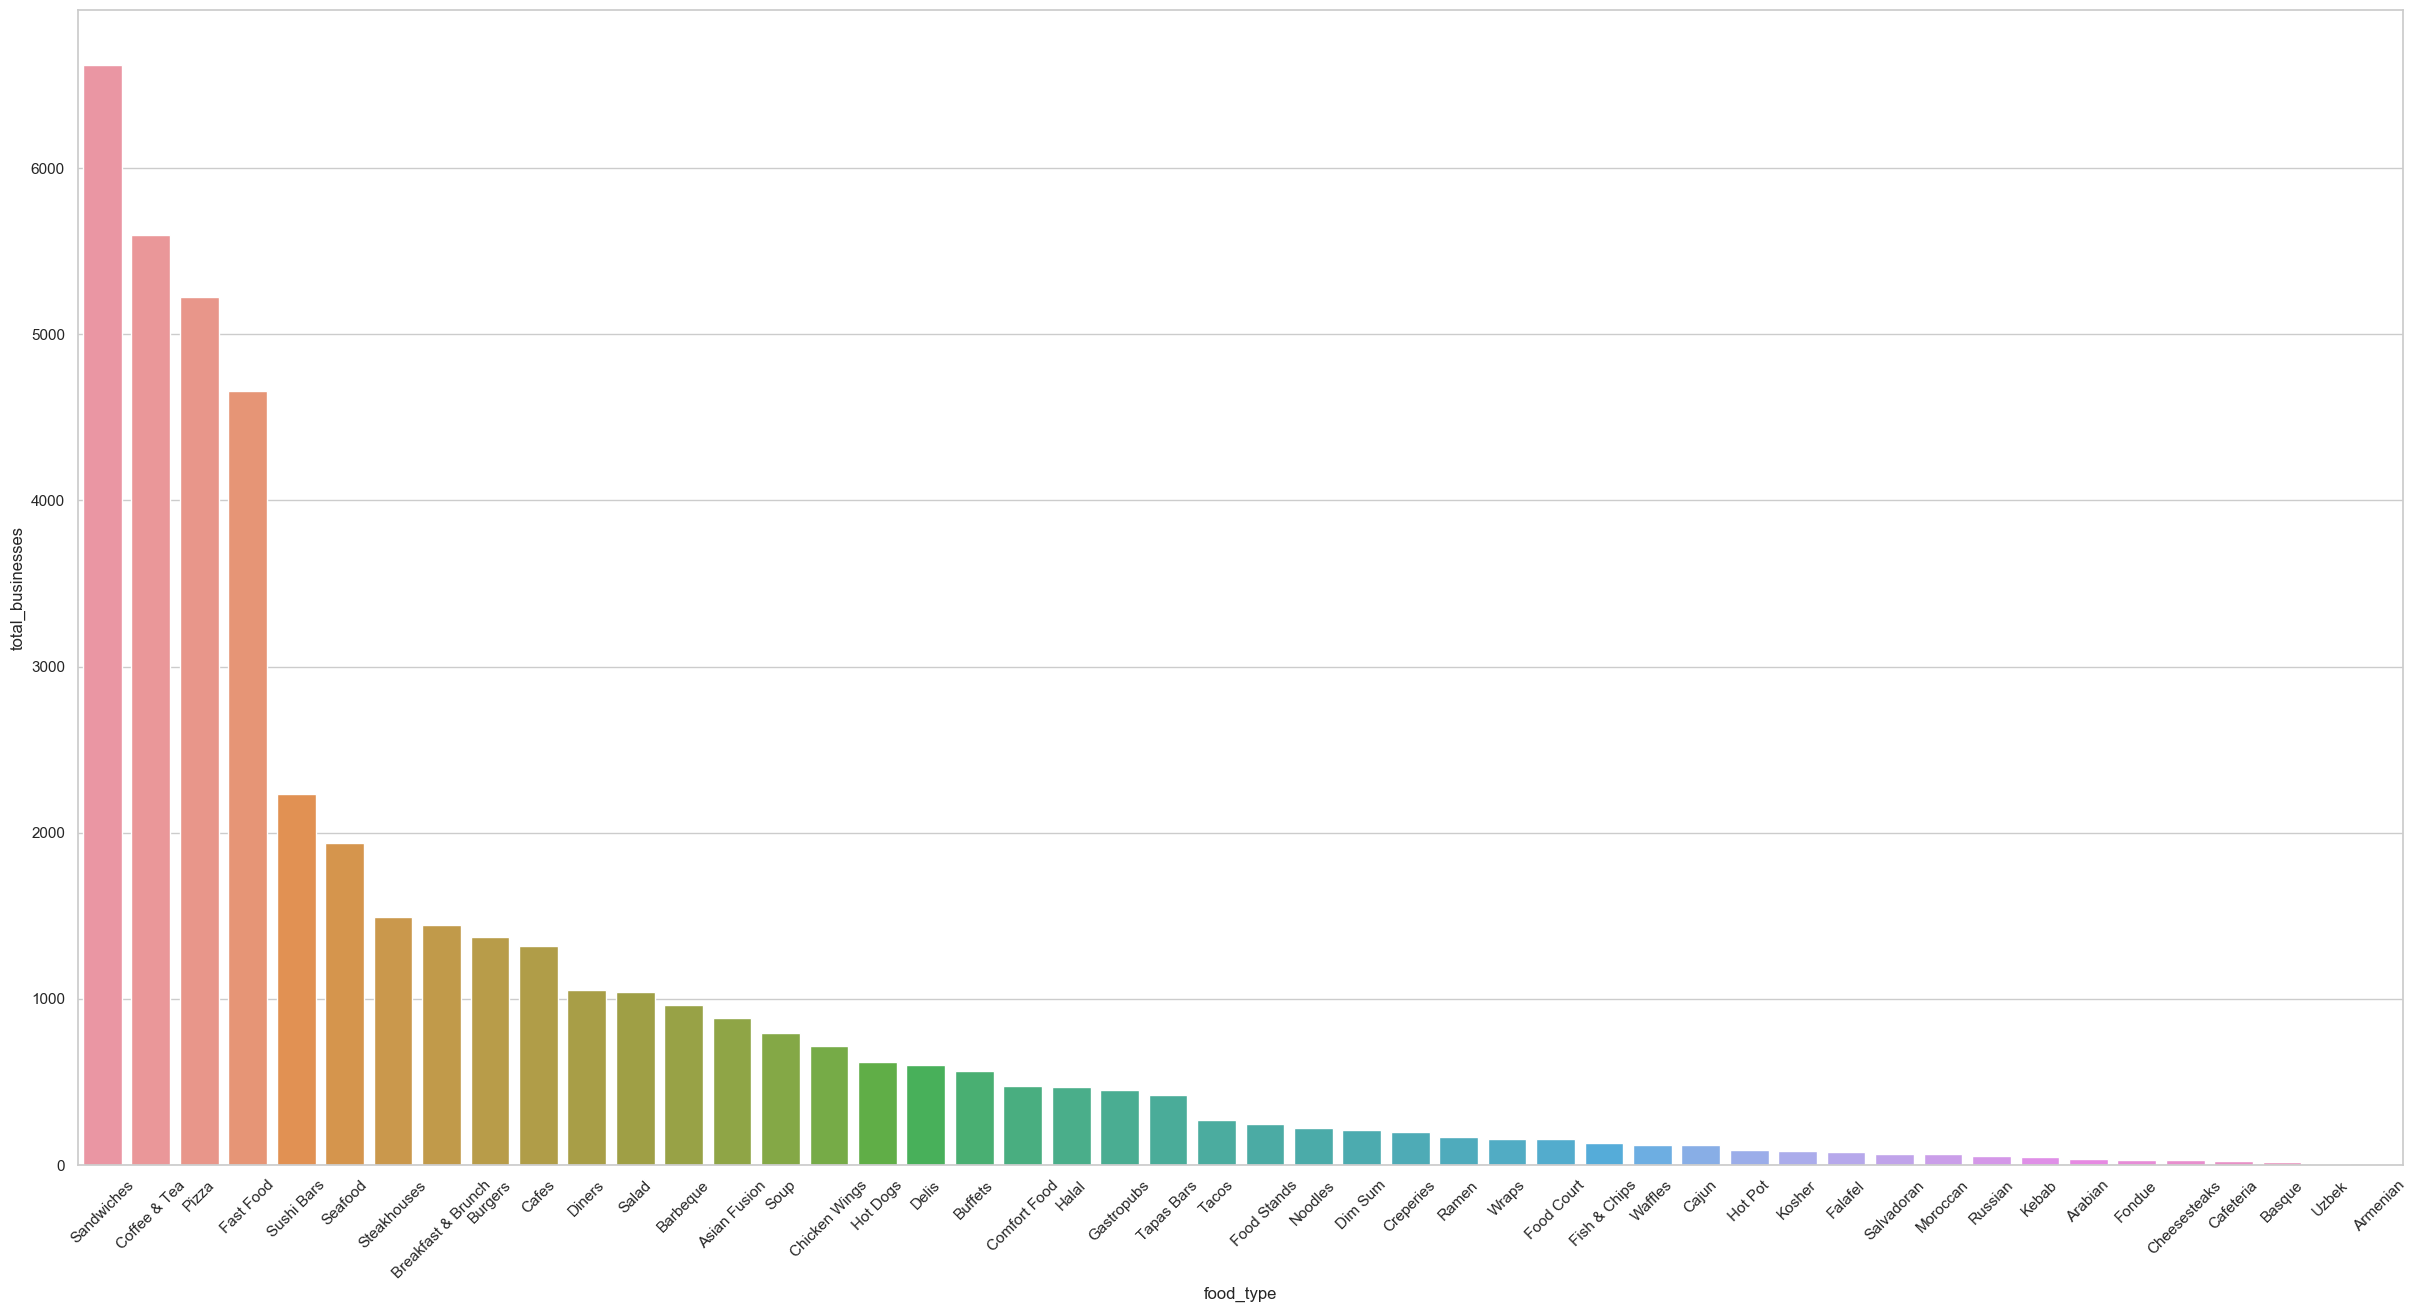

In [47]:
# Since most of the restaurants are classified in a cheaper price range, sandwiches, coffee & tea, and pizza are most common.
sns.set(style="whitegrid")
plt.figure(figsize=(30, 15))
plt.xticks(rotation=45)
sns.barplot(x='food_type', y='total_businesses', data=food);